In [1]:
import numpy as np
import pandas as pd
import arviz as az
import tensorrt
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats
from scipy import interpolate
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt
import seaborn as sns
import math

tfd = tfp.distributions

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

2023-05-10 16:02:02.434592: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 16:02:03.748503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 16:02:03.748586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0e:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 16:02:03.764770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been bu

Num GPUs Available:  2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


### **Preparation**

Probability of having 6 water in 9 tosses with uniform prior

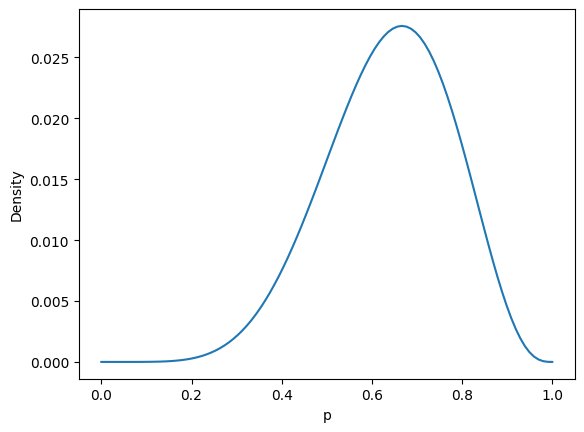

In [2]:
w, n = 6.0, 9.0

p_grid = tf.linspace(0.0, 1.0, 100)

posterior = tfd.Binomial(total_count=n, probs=p_grid).prob(w) * tfd.Uniform(low=0.0, high=1.0).prob(p_grid)

posterior = posterior / tf.reduce_sum(posterior)

plt.plot(p_grid, posterior)
plt.xlabel("p")
plt.ylabel("Density");

In [3]:
with open('./data/Howell1.csv', 'r') as f:
  df = pd.read_csv(f, sep = ';')

In [4]:
print(df.head())
print(df.describe())

    height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0
           height      weight         age        male
count  544.000000  544.000000  544.000000  544.000000
mean   138.263596   35.610618   29.344393    0.472426
std     27.602448   14.719178   20.746888    0.499699
min     53.975000    4.252425    0.000000    0.000000
25%    125.095000   22.007717   12.000000    0.000000
50%    148.590000   40.057844   27.000000    0.000000
75%    157.480000   47.209005   43.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000


           height      weight         age        male
count  352.000000  352.000000  352.000000  352.000000
mean   154.597093   44.990486   41.138494    0.468750
std      7.742332    6.456708   15.967855    0.499733
min    136.525000   31.071052   18.000000    0.000000
25%    148.590000   40.256290   28.000000    0.000000
50%    154.305000   44.792210   39.000000    0.000000
75%    160.655000   49.292693   51.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000


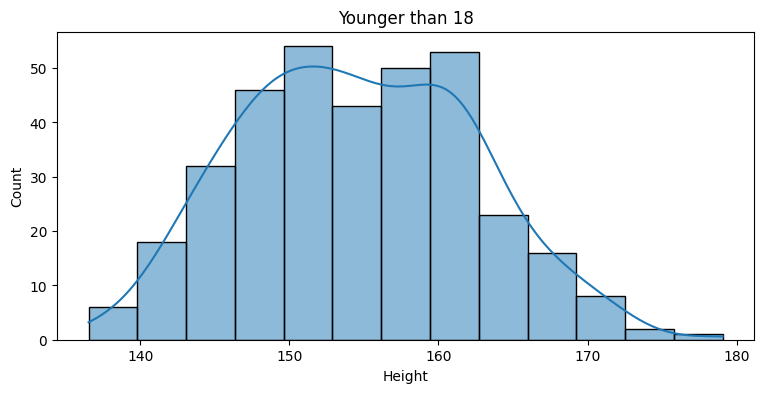

In [5]:
d2_younger18 = df[df['age'] >= 18]
print(d2_younger18.describe())
fig, ax = plt.subplots(figsize=(9, 4))
ax.set(xlabel="Height", ylabel="Count", title="Younger than 18")
#sns.kdeplot(d2_younger18['height'], ax = ax)
#ax.hist(d2_younger18['height'], density = True)
sns.histplot(d2_younger18['height'], kde = True, ax = ax)
#sns.histplot(d2_younger18['height'], ax = ax)
plt.show()
#g = sns.displot(data = d2_younger18['height'], kde = True) # Combined histogram and KDE but it's FacetGrid


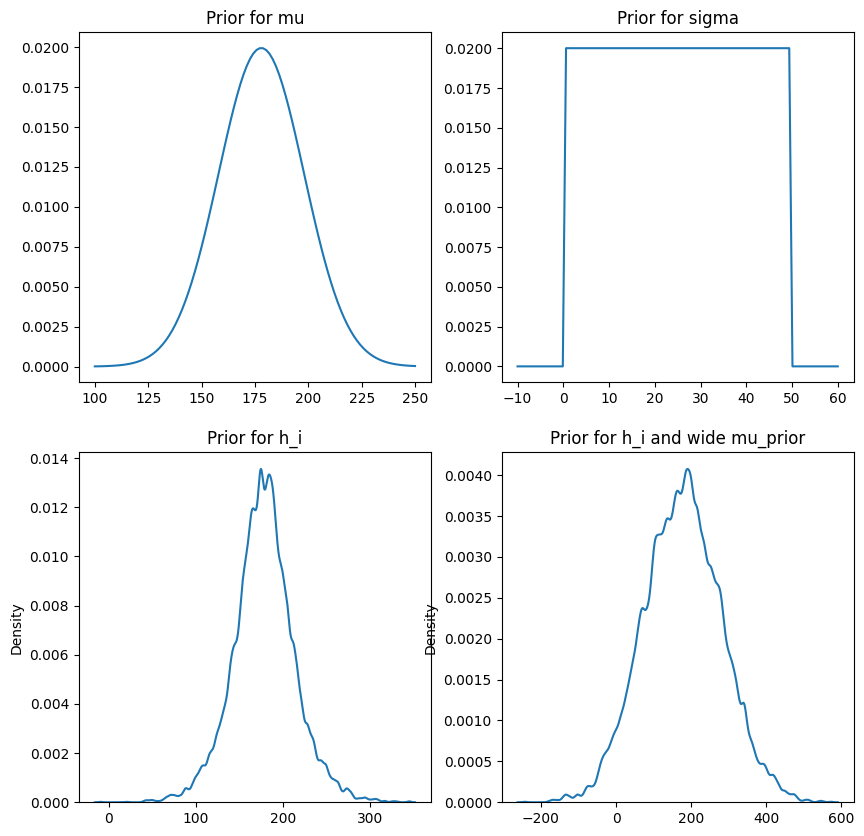

In [6]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
x = tf.linspace(100.0, 250.0, 100)
mu_prior = tfd.Normal(loc = 178, scale = 20)
ax[0,0].set_title("Prior for mu")
ax[0,0].plot(x, mu_prior.prob(x))
x = tf.linspace(-10.0, 60.0, 100)
sigma_prior = tfd.Uniform(low=0.0, high=50.0)
ax[0,1].set_title("Prior for sigma")
ax[0,1].plot(x, sigma_prior.prob(x));

sample_mu = mu_prior.sample(1e4)
sample_sigma = sigma_prior.sample(1e4)
h_prior =  tfd.Normal(loc = sample_mu, scale = sample_sigma).sample()
ax[1,0].set_title("Prior for h_i")
sns.kdeplot(data = h_prior, ax = ax[1,0], gridsize=10000, bw_method = 0.06)

mu_prior = tfd.Normal(loc = 178, scale = 100)
sample_mu = mu_prior.sample(1e4)
h_prior =  tfd.Normal(loc = sample_mu, scale = sample_sigma).sample()
ax[1,1].set_title("Prior for h_i and wide mu_prior")
sns.kdeplot(data = h_prior, ax = ax[1,1], gridsize=10000, bw_method = 0.06)
plt.show()


# **Grid Approzimation**

In [7]:
def compute_likelihood(mu, sigma, sample_data):
    def _compute(i):
        norm_dist = tfd.Normal(loc=mu[i], scale=sigma[i]) #normal distribution for every combination of mu and sigma
        return tf.reduce_sum(norm_dist.log_prob(sample_data)) #calculating the log likelihood of the observations 
                                                                #using the all the normal distribution combinations
                                                                # it's log, so sum instead of multiply
    # use tf.vectorized_map to improve performance                                                        
    return tf.vectorized_map(_compute, np.arange(mu.shape[0]))  #mu.shape[0]: size of the vector

def grid_approximation(
    sample_data, mu_start=150.0, mu_stop=160.0, sigma_start=7.0, sigma_stop=9.0
):
    mu_list = tf.linspace(start=mu_start, stop=mu_stop, num=100)
    sigma_list = tf.linspace(start=sigma_start, stop=sigma_stop, num=100)

    mesh = tf.meshgrid(mu_list, sigma_list) # Creating a grid (100*100)
    mu = tf.reshape(mesh[0], -1)  #converting back to a vector (length = 100*100) Original vector is repeating
    sigma = tf.reshape(mesh[1], -1) #converting back to a vector

    log_likelihood = compute_likelihood(mu, sigma, sample_data)

    # prior distributions (for mu and sigma)
    logprob_mu = tfd.Normal(178.0, 20.0).log_prob(mu)
    logprob_sigma = tfd.Uniform(low=0.0, high=50.0).log_prob(sigma)

    log_joint_prod = log_likelihood + logprob_mu + logprob_sigma
    joint_prob = tf.exp(log_joint_prod - tf.reduce_max(log_joint_prod)) # scaling the data with max(log_joint_prod)
                                                                        # to avoid having all unque probabilities
                                                                        # to be zero due to rounding
                                                                        # The result is 
                                                                        # relative posterior probabilities.
    return mesh, joint_prob

In [8]:
mesh, joint_prob = grid_approximation(tf.cast(d2_younger18.height.values, dtype=tf.float32));

2023-05-10 16:03:29.510073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'loop_body/strided_slice_1/pfor/while/loop_body/strided_slice_1/stack_2' with dtype int64 and shape [1]
	 [[{{node loop_body/strided_slice_1/pfor/while/loop_body/strided_slice_1/stack_2}}]]
2023-05-10 16:03:29.540636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'loop_body/strided_slice/pfor/while/loop_body/strided_slice/stack_2' with dtype int64 and shape [1]
	 [[{{node loop_body/strided_slice/pfor/while/loop_body/strided_slice/stack_2}}]]


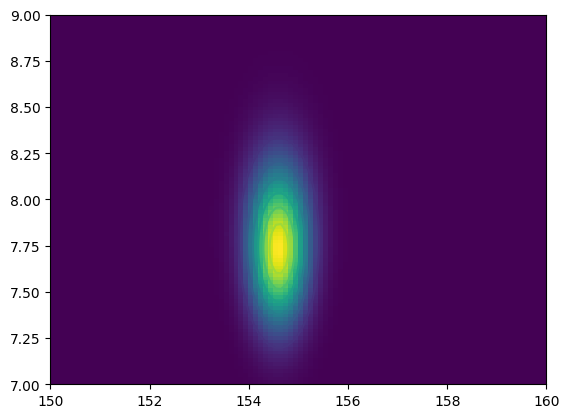

In [9]:
reshaped_joint_prob = tf.reshape(joint_prob, shape=(100, 100))
plt.contour(*mesh, reshaped_joint_prob);
plt.imshow(reshaped_joint_prob, origin="lower", extent=(150, 160, 7, 9), aspect="auto");

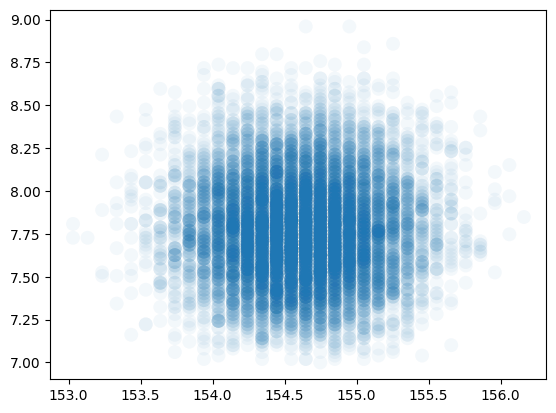

In [10]:
sample_rows = tfd.Categorical(probs=(joint_prob / tf.reduce_sum(joint_prob))).sample(1e4)
mu = tf.reshape(mesh[0], -1)
sigma = tf.reshape(mesh[1], -1)

# We are sampling 2 parameters here from the selected rows
sample_mu = mu.numpy()[sample_rows]
sample_sigma = sigma.numpy()[sample_rows]

plt.scatter(sample_mu, sample_sigma, s=100, alpha=0.05, edgecolor="none");

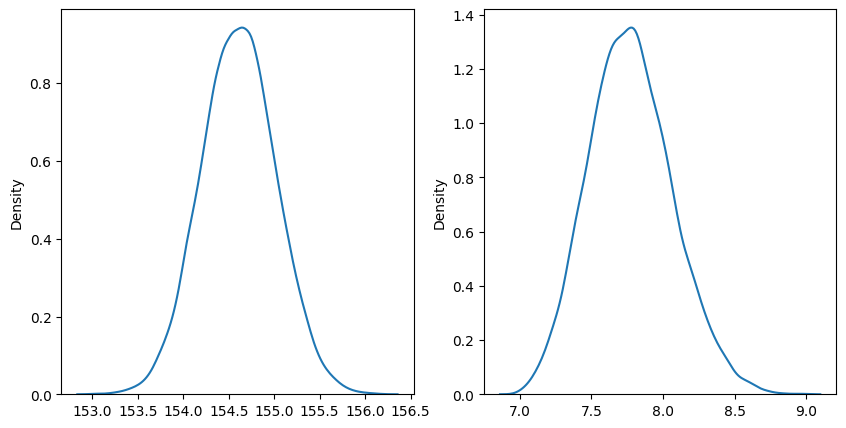

154.61023 0.41084668 [153.93939209 155.25253296]
7.7745476 0.29184029 [7.32323217 8.27272701]


In [11]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.kdeplot(data = sample_mu, ax = ax[0])
sns.kdeplot(data = sample_sigma, ax = ax[1])
plt.show()
print(np.mean(sample_mu),np.std(sample_mu),np.percentile(sample_mu,[5.5,94.5]))
print(np.mean(sample_sigma),np.std(sample_sigma),np.percentile(sample_sigma,[5.5,94.5]))

# **Quadratic Approximation**

In [12]:
with open('./data/Howell1.csv', 'r') as f:
  df = pd.read_csv(f, sep = ';')

### **Simple Model**

2023-05-10 16:04:18.126194: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x559874ca00e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-10 16:04:18.126232: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-05-10 16:04:18.126239: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2023-05-10 16:04:18.130112: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-10 16:04:20.203392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-10 16:04:20.327459: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


             Mean  Standard Deviation        5.5%       94.5%
mu     154.607040            0.411994  153.950439  155.265778
sigma    7.731332            0.291386    7.265862    8.197954


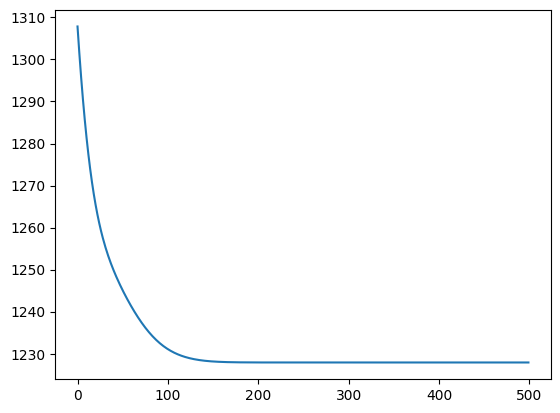

In [13]:
def log_posterior_normal_uniform(mu, sigma, data):
  mu_dist = tfd.Normal(loc=178., scale=20.)
  sigma_dist = tfd.Uniform(low=0., high=50.)
  height_dist = tfd.Normal(loc=mu, scale=sigma)
  return (
      mu_dist.log_prob(mu) +
      sigma_dist.log_prob(sigma) +           
      tf.reduce_sum(height_dist.log_prob(data)) 
  )

def Mean_Quadratic(mu, sigma, data):
  losses = tfp.math.minimize(
    lambda: -log_posterior_normal_uniform(mu, sigma, data),
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=500)
  plt.plot(losses);
  return tf.reduce_mean(mu).numpy(), tf.reduce_mean(sigma).numpy()

def STD_Quadratic(x, constant, Func, Var):
  with tf.GradientTape() as g:
    g.watch(x)
    with tf.GradientTape() as gg:
      gg.watch(x)
      if (Var == "mu"):
        y = -Func(x, constant)
      else:
        y = -Func(constant, x)
    dy_dx = gg.gradient(y, x)
  return ((1/g.gradient(dy_dx, x))**0.5 ).numpy()

mu_mean, sigma_mean = Mean_Quadratic(tf.Variable(150.), tf.Variable(7.), d2_younger18.height)
Posterior_log_prob = lambda mu, sigma: log_posterior_normal_uniform(mu, sigma, d2_younger18.height)

mu_std = STD_Quadratic(tf.constant(mu_mean), sigma_mean, Posterior_log_prob, "mu")
sigma_std = STD_Quadratic(tf.constant(sigma_mean), mu_mean, Posterior_log_prob, "sigma")

mu_est = tfd.Normal(loc=mu_mean, scale=mu_std).sample(5e5).numpy()
sigma_est = tfd.Normal(loc=sigma_mean, scale=sigma_std).sample(5e5).numpy()

Quadratic_est = pd.DataFrame({'Mean': pd.Series({'mu': mu_mean, 'sigma': sigma_mean}),
                              'Standard Deviation': pd.Series({'mu': mu_std, 'sigma': sigma_std}),
                              '5.5%': pd.Series({'mu': np.percentile(mu_est,5.5), 'sigma': np.percentile(sigma_est,5.5)}),
                              '94.5%': pd.Series({'mu': np.percentile(mu_est,94.5), 'sigma': np.percentile(sigma_est,94.5)})
                              })

print(Quadratic_est)

### **Means as initial value (alternative defenition for model)**

             Mean  Standard Deviation        5.5%       94.5%
mu     154.607056            0.411994  153.951581  155.261750
sigma    7.731333            0.291386    7.264158    8.205439


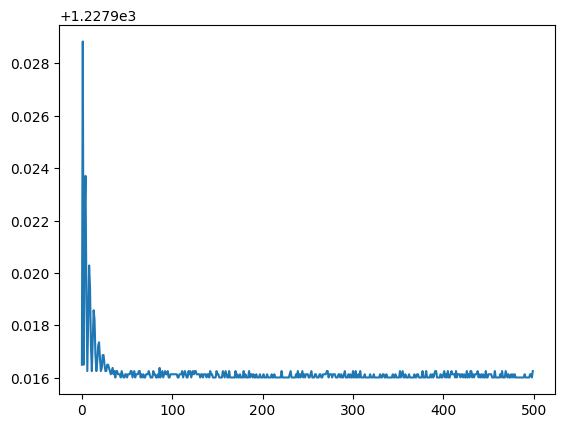

In [14]:
def model_normal_uniform():
  mu = yield tfd.Normal(loc=178.0, scale=20.0, name = "mu")
  sigma = yield tfd.Uniform(low=0.0, high=50.0, name = "sigma")
  height = yield tfd.Normal(loc=mu, scale=sigma, name = "height")

def compute_log_likelihood(mu, sigma, data):
  def _compute(i):
    return tf.reduce_sum(model_4_1.log_prob_parts([tf.cast(mu, dtype=tf.float32),
                                                   tf.cast(sigma, dtype=tf.float32),
                                                   tf.cast(data, dtype=tf.float32)])[2])
  return tf.vectorized_map(_compute, np.arange(1))

def Mean_Quadratic(mu, sigma, Func, data):
  losses = tfp.math.minimize(
    lambda: -Func(mu, sigma),
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=500)
  plt.plot(losses);
  return tf.reduce_mean(mu).numpy(), tf.reduce_mean(sigma).numpy()

def STD_Quadratic(x, constant, data, Func, Var):
  with tf.GradientTape() as g:
    g.watch(x)
    with tf.GradientTape() as gg:
      gg.watch(x)
      if (Var == "mu"):
        y = -Func(x, constant)
      else:
        y = -Func(constant, x)
    dy_dx = gg.gradient(y, x)
  return ((1/g.gradient(dy_dx, x))**0.5 ).numpy()

model_4_1 = tfd.JointDistributionCoroutineAutoBatched(model_normal_uniform)
Data = d2_younger18.height

posterior_log_prob = lambda mu, sigma: compute_log_likelihood(mu, sigma, Data) +\
 model_4_1.log_prob_parts([mu,sigma,170.])[0] +\
 model_4_1.log_prob_parts([mu,sigma,170.])[1]   #loglikelihood+log_prior for mu+log_prior for sigma

mu_initial = tf.constant(np.mean(Data.values, dtype = np.float32))
sigma_initial = tf.constant(np.std(Data.values, dtype = np.float32))

mu_mean, sigma_mean = Mean_Quadratic(tf.Variable(mu_initial), tf.Variable(sigma_initial), posterior_log_prob, tf.Variable(Data))
mu_std = STD_Quadratic(tf.constant(mu_mean), sigma_mean, Data, posterior_log_prob, "mu")
sigma_std = STD_Quadratic(tf.constant(sigma_mean), mu_mean, Data, posterior_log_prob, "sigma")

mu_est = tfd.Normal(loc=mu_mean, scale=mu_std).sample(1e4).numpy()
sigma_est = tfd.Normal(loc=sigma_mean, scale=sigma_std).sample(1e4).numpy()

Quadratic_est = pd.DataFrame({'Mean': pd.Series({'mu': mu_mean, 'sigma': sigma_mean}),
                              'Standard Deviation': pd.Series({'mu': mu_std, 'sigma': sigma_std}),
                              '5.5%': pd.Series({'mu': np.percentile(mu_est,5.5), 'sigma': np.percentile(sigma_est,5.5)}),
                              '94.5%': pd.Series({'mu': np.percentile(mu_est,94.5), 'sigma': np.percentile(sigma_est,94.5)})
                              })
print(Quadratic_est)

### **Narrower prior**

             Mean  Standard Deviation        5.5%       94.5%
mu     177.862183            0.099708  177.704894  178.023017
sigma   24.515724            0.923952   23.035147   25.966248


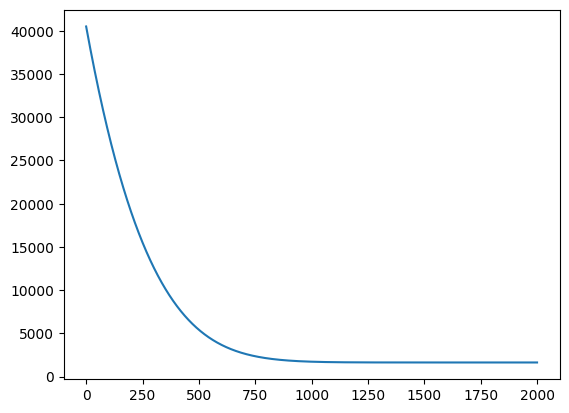

In [15]:
def log_posterior_normal_uniform(mu, sigma, data):
  mu_dist = tfd.Normal(loc=178., scale=0.1)
  sigma_dist = tfd.Uniform(low=0., high=50.)
  height_dist = tfd.Normal(loc=mu, scale=sigma)
  return (
      mu_dist.log_prob(mu) +
      sigma_dist.log_prob(sigma) +           
      tf.reduce_sum(height_dist.log_prob(data)) 
  )

def Mean_Quadratic(mu, sigma, data):
  losses = tfp.math.minimize(
    lambda: -log_posterior_normal_uniform(mu, sigma, data),
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=2000)
  plt.plot(losses);
  return tf.reduce_mean(mu).numpy(), tf.reduce_mean(sigma).numpy()

def STD_Quadratic(x, constant, data, Func, Var):
  with tf.GradientTape() as g:
    g.watch(x)
    with tf.GradientTape() as gg:
      gg.watch(x)
      if (Var == "mu"):
        y = -Func(x, constant)
      else:
        y = -Func(constant, x)
    dy_dx = gg.gradient(y, x)
  return ((1/g.gradient(dy_dx, x))**0.5 ).numpy()

Data = d2_younger18.height
mu_initial = tf.constant(np.mean(Data.values, dtype = np.float32))
sigma_initial = tf.constant(np.std(Data.values, dtype = np.float32))

mu_mean, sigma_mean = Mean_Quadratic(tf.Variable(150.), tf.Variable(7.), Data)
Posterior_log_prob = lambda mu, sigma: log_posterior_normal_uniform(mu, sigma, Data)

mu_std = STD_Quadratic(tf.constant(mu_mean), sigma_mean, Data, Posterior_log_prob, "mu")
sigma_std = STD_Quadratic(tf.constant(sigma_mean), mu_mean, Data, Posterior_log_prob, "sigma")

mu_est = tfd.Normal(loc=mu_mean, scale=mu_std).sample(1e4).numpy()
sigma_est = tfd.Normal(loc=sigma_mean, scale=sigma_std).sample(1e4).numpy()

Quadratic_est = pd.DataFrame({'Mean': pd.Series({'mu': mu_mean, 'sigma': sigma_mean}),
                              'Standard Deviation': pd.Series({'mu': mu_std, 'sigma': sigma_std}),
                              '5.5%': pd.Series({'mu': np.percentile(mu_est,5.5), 'sigma': np.percentile(sigma_est,5.5)}),
                              '94.5%': pd.Series({'mu': np.percentile(mu_est,94.5), 'sigma': np.percentile(sigma_est,94.5)})
                              })

print(Quadratic_est)

### **Covariance**

In [16]:
print(np.cov(np.stack((mu_est, sigma_est), axis=0)))
print(np.corrcoef(mu_est, sigma_est))

[[ 9.92302363e-03 -3.73683531e-04]
 [-3.73683531e-04  8.41158338e-01]]
[[ 1.         -0.00409019]
 [-0.00409019  1.        ]]


# **Linear Prediction**

In [17]:
with open('./data/Howell1.csv', 'r') as f:
  df = pd.read_csv(f, sep = ';')
Height = df[df['age'] >= 18].height
Weight = df[df['age'] >= 18].weight

### **Exploring Priors**

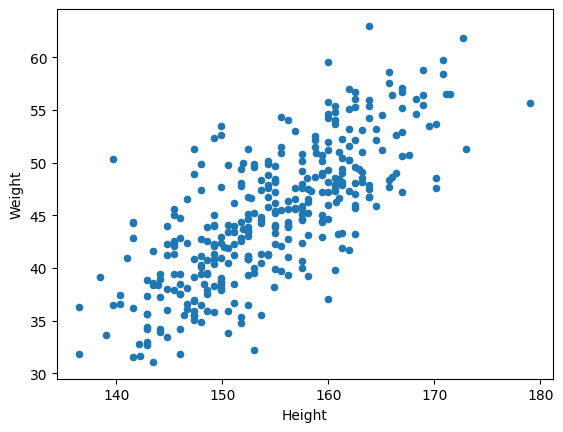

In [18]:
plt.xlabel("Height")
plt.ylabel("Weight");
plt.scatter(Height, Weight, s=20, alpha=1);

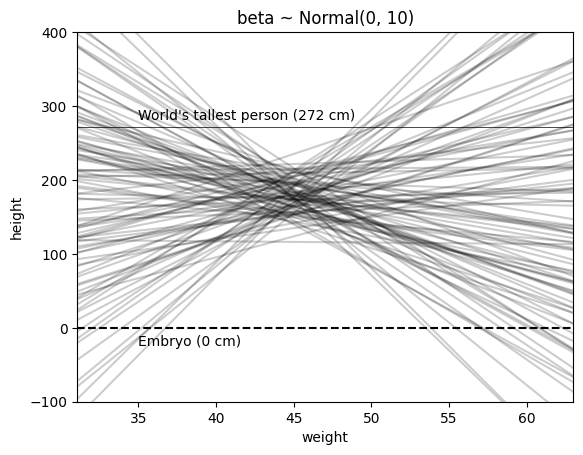

In [19]:
N = 100

alpha = tfd.Normal(loc=178.0, scale=20.0).sample(N)
beta = tfd.Normal(loc=0.0, scale=10.0).sample(N)

plt.subplot(
    xlim=(Weight.min(), Weight.max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("beta ~ Normal(0, 10)")
xbar = Weight.mean()
x = np.linspace(Weight.min(), Weight.max(), 1000)
for i in range(N):
    plt.plot(x, alpha[i] + beta[i] * (x - xbar), "k", alpha=0.2)

plt.text(x=35, y=282, s="World's tallest person (272 cm)")
plt.text(x=35, y=-25, s="Embryo (0 cm)");

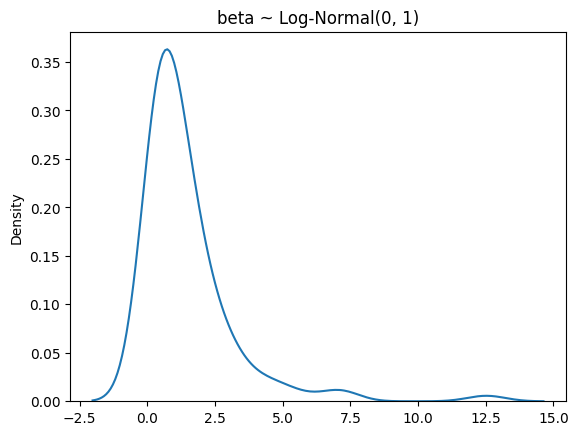

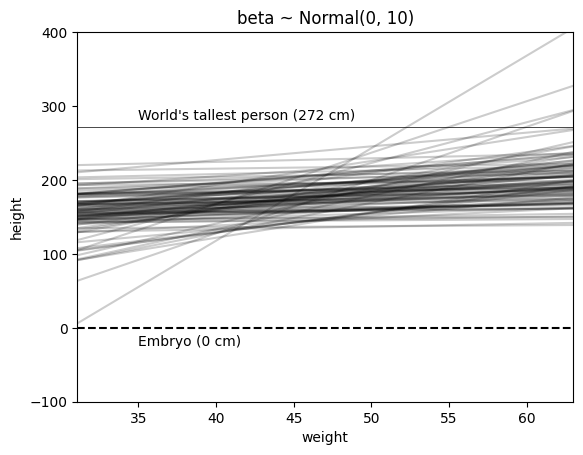

In [20]:
N = 100

alpha = tfd.Normal(loc=178.0, scale=20.0).sample(N)
beta = tfd.LogNormal(loc=0.0, scale=1.0).sample(N)
sns.kdeplot(data = beta)
plt.title("beta ~ Log-Normal(0, 1)")
plt.show()

plt.subplot(
    xlim=(Weight.min(), Weight.max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("beta ~ Normal(0, 10)")
xbar = Weight.mean()
x = np.linspace(Weight.min(), Weight.max(), 1000)
for i in range(N):
  plt.plot(x, alpha[i] + beta[i] * (x - xbar), "k", alpha=0.2)
plt.text(x=35, y=282, s="World's tallest person (272 cm)")
plt.text(x=35, y=-25, s="Embryo (0 cm)");
plt.show()

## **Linear Regression**

             Mean  Standard Deviation    5.5%   94.5%
Alpha  154.600006                0.27  154.17  155.03
Beta     0.900000                0.04    0.84    0.97
Sigma    5.070000                0.19    4.77    5.37
[[ 0.073 -0.    -0.   ]
 [-0.     0.002  0.   ]
 [-0.     0.     0.036]]


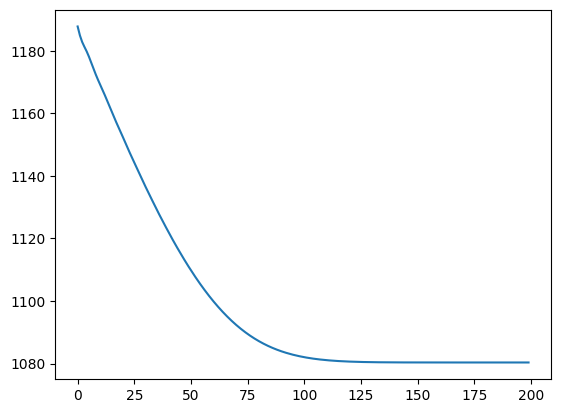

In [21]:
dtype = tf.float32

X = Weight
xbar = tf.reduce_mean(X)
Y = Height

def log_posterior_LR1(alpha, beta, sigma, data):
  alpha_prior = tfd.Normal(loc=178., scale=20.0)
  beta_prior = tfd.LogNormal(loc=0., scale=1.0)
  sigma_prior = tfd.Uniform(low=0., high=50.)
  mu = alpha + tf.cast(beta,dtype)*tf.cast(X.values[:] - xbar,dtype)
  Y_likelihood = tfd.Normal(loc= mu, scale= sigma)
  return (
      alpha_prior.log_prob(alpha) +\
      beta_prior.log_prob(beta) +\
      sigma_prior.log_prob(sigma) +\
      tf.reduce_sum(Y_likelihood.log_prob(data))
      )

def Mean_Quadratic(alpha, beta, sigma, data):
  losses = tfp.math.minimize(
      lambda: -log_posterior_LR1(alpha, beta, sigma, data),
      optimizer=tf.optimizers.Adam(learning_rate=0.05),
      num_steps=200)
  plt.plot(losses);
  return alpha.numpy(), beta.numpy(), sigma.numpy()

def STD_Quadratic(alpha, beta, sigma, Func):
  with tf.GradientTape() as g:
    g.watch(alpha)
    with tf.GradientTape() as gg:
      gg.watch(alpha)
      y = -Func(alpha, beta, sigma)
    dy_dalpha = gg.gradient(y, alpha)
  d2y_d2alpha = g.gradient(dy_dalpha, alpha)
  with tf.GradientTape() as g:
    g.watch(beta)
    with tf.GradientTape() as gg:
      gg.watch(beta)
      y = -Func(alpha, beta, sigma)
    dy_dbeta = gg.gradient(y, beta)
  d2y_d2beta = g.gradient(dy_dbeta, beta)
  with tf.GradientTape() as g:
    g.watch(sigma)
    with tf.GradientTape() as gg:
      gg.watch(sigma)
      y = -Func(alpha, beta, sigma)
    dy_dsigma = gg.gradient(y, sigma)
  d2y_d2sigma = g.gradient(dy_dsigma, sigma)
  return (
      ((1/d2y_d2alpha)**0.5 ).numpy(),
      ((1/d2y_d2beta)**0.5 ).numpy(),
      ((1/d2y_d2sigma)**0.5 ).numpy()
  )

log_posterior_LR1_forDerivation = lambda alpha, beta, sigma: log_posterior_LR1(alpha, beta, sigma, Y)

Mean = Mean_Quadratic(tf.Variable(150.), tf.Variable(1.), tf.Variable(7.), Y)
STD = STD_Quadratic(tf.convert_to_tensor(Mean[0]), tf.convert_to_tensor(Mean[1]), tf.convert_to_tensor(Mean[2]), log_posterior_LR1_forDerivation)

alpha_est = tfd.Normal(loc=Mean[0], scale=STD[0]).sample(1e4).numpy()
beta_est = tfd.Normal(loc=Mean[1], scale=STD[1]).sample(1e4).numpy()
sigma_est = tfd.Normal(loc=Mean[2], scale=STD[2]).sample(1e4).numpy()

Quadratic_est = pd.DataFrame({'Mean': pd.Series({'Alpha': Mean[0], 'Beta': Mean[1], 'Sigma': Mean[2]}),
                              'Standard Deviation': pd.Series({'Alpha': STD[0], 'Beta': STD[1], 'Sigma': STD[2]}),
                              '5.5%': pd.Series({'Alpha': np.percentile(alpha_est,5.5), 'Beta': np.percentile(beta_est,5.5), 'Sigma': np.percentile(sigma_est,5.5)}),
                              '94.5%': pd.Series({'Alpha': np.percentile(alpha_est,94.5), 'Beta': np.percentile(beta_est,94.5), 'Sigma': np.percentile(sigma_est,94.5)})
                              })
print(np.round(Quadratic_est, 2))

print(np.round(np.cov(np.stack((alpha_est, beta_est, sigma_est), axis = 0)),3))

### **Plot the Posterior**

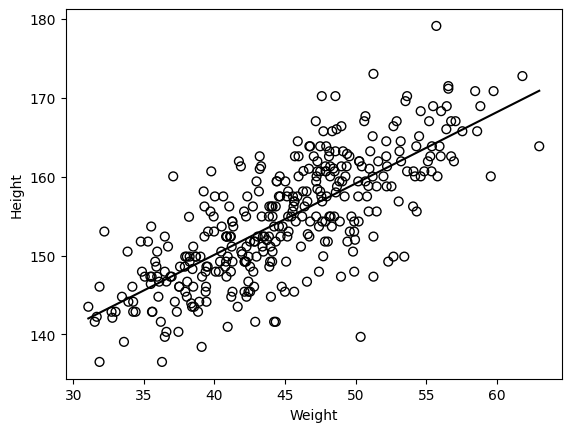

In [22]:
alpha_map = tf.reduce_mean(alpha_est)
beta_map = tf.reduce_mean(beta_est)

x = np.linspace(Weight.min(), Weight.max(), 101)

plt.xlabel("Weight")
plt.ylabel("Height");
plt.scatter(Weight, Height, s=40, alpha=1, facecolors='None', edgecolors = 'k', marker = "o");
y = alpha_map + tf.cast(beta_map,dtype)*tf.cast(x - xbar,dtype)
plt.plot(x, y, "k");

### **Scatter Lines**

             Mean  Standard Deviation        5.5%       94.5%
Alpha  152.752670            1.491265  150.330566  155.087780
Beta     0.928908            0.140547    0.705059    0.705059
Sigma    4.486282            1.057451    2.798267    6.177608
[[2.210e+00 3.000e-03 1.700e-02]
 [3.000e-03 2.000e-02 1.000e-03]
 [1.700e-02 1.000e-03 1.119e+00]]
             Mean  Standard Deviation        5.5%       94.5%
Alpha  152.823395            0.689527  151.703763  153.897592
Beta     0.885078            0.094137    0.732135    0.732135
Sigma    4.829563            0.487857    4.062773    5.624113
[[ 0.472 -0.     0.   ]
 [-0.     0.009  0.   ]
 [ 0.     0.     0.24 ]]
             Mean  Standard Deviation        5.5%       94.5%
Alpha  154.334808            0.444868  153.640075  155.039329
Beta     0.899515            0.063801    0.796422    0.796422
Sigma    5.431650            0.314647    4.925120    5.919172
[[ 0.195  0.     0.   ]
 [ 0.     0.004 -0.   ]
 [ 0.    -0.     0.099]]
          

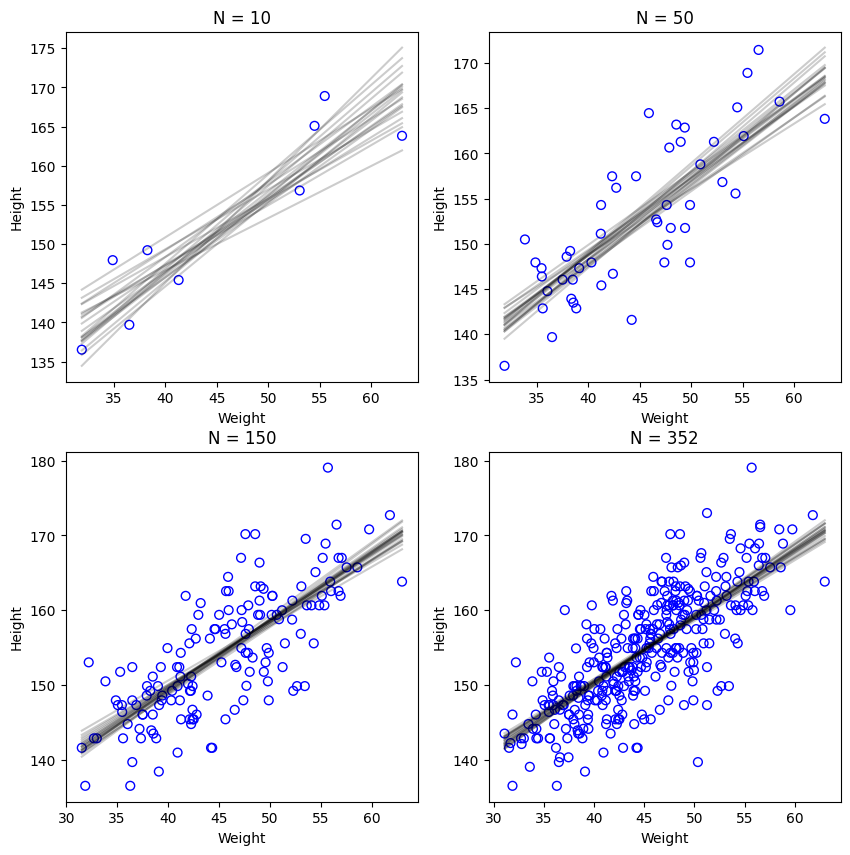

In [23]:
dtype = tf.float32
fig, ax = plt.subplots(2,2, figsize=(10, 10))
n = 20  #number of samples from posterior
#N = 150  #number of data samples
axi = [[0,0],[0,1],[1,0],[1,1]]
jj = -1

for j in [10,50,150,352]:
  jj += 1
  X = Weight[1:j]
  Y = Height[1:j]
  xbar = tf.reduce_mean(X)

  def log_posterior_LR1(alpha, beta, sigma, data):
    alpha_prior = tfd.Normal(loc=178., scale=20.0)
    beta_prior = tfd.LogNormal(loc=0., scale=1.0)
    sigma_prior = tfd.Uniform(low=0., high=50.)
    mu = alpha + tf.cast(beta,dtype)*tf.cast(X.values[:] - xbar,dtype)
    Y_likelihood = tfd.Normal(loc= mu, scale= sigma)
    return (
        alpha_prior.log_prob(alpha) +\
        beta_prior.log_prob(beta) +\
        sigma_prior.log_prob(sigma) +\
        tf.reduce_sum(Y_likelihood.log_prob(data))
        )

  def Mean_Quadratic(alpha, beta, sigma, data):
    losses = tfp.math.minimize(
        lambda: -log_posterior_LR1(alpha, beta, sigma, data),
        optimizer=tf.optimizers.Adam(learning_rate=0.05),
        num_steps=200)
    #plt.plot(losses);
    #plt.show()
    return alpha.numpy(), beta.numpy(), sigma.numpy()

  def STD_Quadratic(alpha, beta, sigma, Func):
    with tf.GradientTape() as g:
      g.watch(alpha)
      with tf.GradientTape() as gg:
        gg.watch(alpha)
        y = -Func(alpha, beta, sigma)
      dy_dalpha = gg.gradient(y, alpha)
    d2y_d2alpha = g.gradient(dy_dalpha, alpha)
    with tf.GradientTape() as g:
      g.watch(beta)
      with tf.GradientTape() as gg:
        gg.watch(beta)
        y = -Func(alpha, beta, sigma)
      dy_dbeta = gg.gradient(y, beta)
    d2y_d2beta = g.gradient(dy_dbeta, beta)
    with tf.GradientTape() as g:
      g.watch(sigma)
      with tf.GradientTape() as gg:
        gg.watch(sigma)
        y = -Func(alpha, beta, sigma)
      dy_dsigma = gg.gradient(y, sigma)
    d2y_d2sigma = g.gradient(dy_dsigma, sigma)
    return (
        ((1/d2y_d2alpha)**0.5 ).numpy(),
        ((1/d2y_d2beta)**0.5 ).numpy(),
        ((1/d2y_d2sigma)**0.5 ).numpy()
    )


  log_posterior_LR1_forDerivation = lambda alpha, beta, sigma: log_posterior_LR1(alpha, beta, sigma, Y)

  Mean = Mean_Quadratic(tf.Variable(150.), tf.Variable(1.), tf.Variable(7.), Y)
  STD = STD_Quadratic(tf.convert_to_tensor(Mean[0]), tf.convert_to_tensor(Mean[1]), tf.convert_to_tensor(Mean[2]), log_posterior_LR1_forDerivation)

  alpha_est = tfd.Normal(loc=Mean[0], scale=STD[0]).sample(1e4).numpy()
  beta_est = tfd.Normal(loc=Mean[1], scale=STD[1]).sample(1e4).numpy()
  sigma_est = tfd.Normal(loc=Mean[2], scale=STD[2]).sample(1e4).numpy()

  Quadratic_est = pd.DataFrame({'Mean': pd.Series({'Alpha': Mean[0], 'Beta': Mean[1], 'Sigma': Mean[2]}),
                                'Standard Deviation': pd.Series({'Alpha': STD[0], 'Beta': STD[1], 'Sigma': STD[2]}),
                                '5.5%': pd.Series({'Alpha': np.percentile(alpha_est,5.5), 'Beta': np.percentile(beta_est,5.5), 'Sigma': np.percentile(sigma_est,5.5)}),
                                '94.5%': pd.Series({'Alpha': np.percentile(alpha_est,94.5), 'Beta': np.percentile(beta_est,5.5), 'Sigma': np.percentile(sigma_est,94.5)})
                                })
  print(Quadratic_est)

  print(np.round(np.cov(np.stack((alpha_est, beta_est, sigma_est), axis = 0)),3))

  alpha_map = tf.reduce_mean(alpha_est)
  beta_map = tf.reduce_mean(beta_est)

  x = np.linspace(X.min(), X.max(), 101)

  ax[axi[jj][0],axi[jj][1]].set_xlabel("Weight")
  ax[axi[jj][0],axi[jj][1]].set_ylabel("Height");
  ax[axi[jj][0],axi[jj][1]].set_title("N = "+str(j))
  ax[axi[jj][0],axi[jj][1]].scatter(X, Y, s=40, alpha=1, facecolors='None', edgecolors = 'b', marker = "o");

  alpha_est = tfd.Normal(loc=Mean[0], scale=STD[0]).sample(N).numpy()
  beta_est = tfd.Normal(loc=Mean[1], scale=STD[1]).sample(N).numpy()

  for i in range(n):
      ax[axi[jj][0],axi[jj][1]].plot(x, alpha_est[i] + beta_est[i] * (x - xbar), "k", alpha=0.2)

  #plt.show()

### **At specific weight**

tf.Tensor(
[158.552959   159.49277475 159.12766106 158.7973698  159.57940117
 159.63932572 159.15381973 158.83156412 159.11707231 159.19577345
 159.17605223 159.45239632 159.38589503 159.09651221 158.97701889
 159.19155897 158.8685201  159.28422496 158.79890683 159.007451
 159.07498626 158.87112525 159.40721209 159.4799887  159.21620932
 159.25137057 159.06540867 159.10999804 158.53578712 158.95738273
 159.61151771 158.46406834 158.43714719 159.24574672 158.70739846
 159.03755034 158.84103456 159.43194187 159.42567792 159.76233685
 159.22692891 159.06063078 159.05994345 159.41821521 158.89509047
 158.99221712 159.46700296 159.11559718 158.60149348 160.11713938
 159.25814626 159.17179432 159.57996328 159.45815217 159.36128783
 159.36274818 159.7510245  159.04077583 158.9547516  159.10095752
 159.60872004 158.81322558 159.44502765 158.89874443 158.76359875
 159.08270296 158.95276742 159.51062637 159.09767597 159.25175879
 159.72378107 159.3413443  158.94074842 159.40499148 159.78859753
 

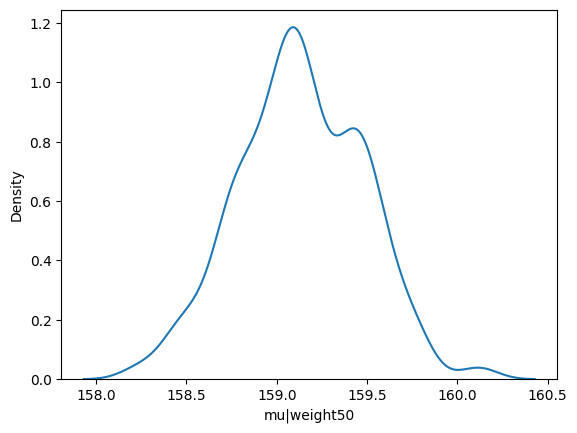

[158.55210041 159.61318619]
[158.69156939 159.76233685]


In [24]:
mu_at_50 = alpha_est + beta_est * (50 - xbar)
print(mu_at_50)
sns.kdeplot(data = mu_at_50, gridsize=10000, bw_method = 0.3)
plt.xlabel("mu|weight50")
plt.show()
print(np.percentile(mu_at_50, [5,94])) # 89% percentile
print(az.hdi(mu_at_50.numpy(), hdi_prob=0.89))  # HPDI

### **Sampling mu**

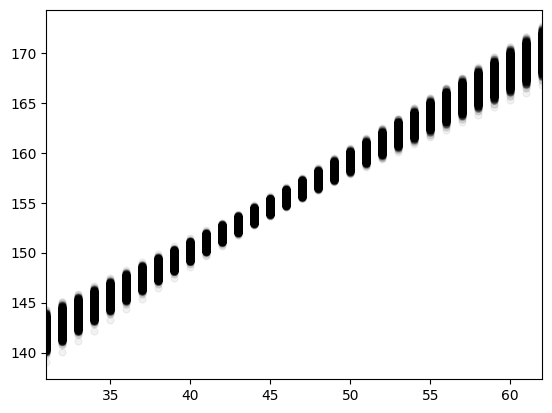

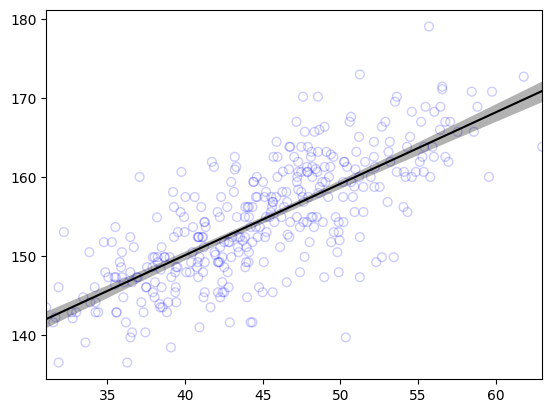

In [25]:
# First run the simulation ...
N = 10000
alpha_est = tfd.Normal(loc=Mean[0], scale=STD[0]).sample(N).numpy()
beta_est = tfd.Normal(loc=Mean[1], scale=STD[1]).sample(N).numpy()
mu_pred = np.zeros((N,len(X)))

x = np.arange(np.round(X.min()), np.round(X.max()))
for i in range(len(x)):
  mu_pred[:,i] = alpha_est + beta_est * (x[i] - xbar)
  plt.scatter(x[i]*np.ones(N), mu_pred[:,i],
              s=100,
              alpha=0.05,
              facecolors='k',
              marker = ".");
  plt.xlim([x.min(), x.max()])
plt.show()

x = np.linspace(X.min(),X.max(), len(X))
for i in range(len(x)):
  mu_pred[:,i] = alpha_est + beta_est * (x[i] - xbar)
mu_mean = np.mean(mu_pred, axis= 0)
mu_PI_89 = np.percentile(mu_pred, [5,94], axis= 0)

plt.xlim([np.min(x),np.max(x)])
plt.scatter(X, Y, s=40, alpha=0.2, facecolors='None', edgecolors = 'b', marker = "o")
plt.plot(x, mu_mean, '-k')
#print(mu_PI_89[0,:])
plt.fill_between(x, mu_PI_89[0,:], mu_PI_89[1,:], alpha=0.3, linewidth=0, color = 'k')
plt.show()

### **Prediction Intervals**

**Lenght = lenght of data**

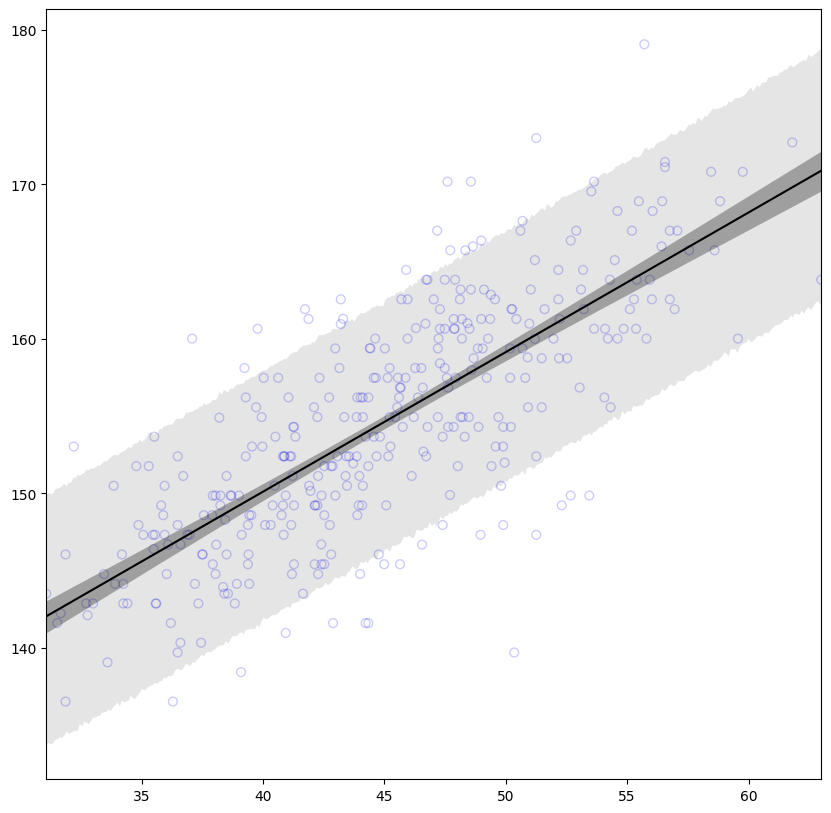

In [26]:
N = 10000

alpha_est = tfd.Normal(loc=Mean[0], scale=STD[0]).sample(N).numpy()
beta_est = tfd.Normal(loc=Mean[1], scale=STD[1]).sample(N).numpy()
sigma_est = tfd.Normal(loc=Mean[2], scale=STD[2]).sample(N).numpy()

mu_pred = np.zeros((N,len(X)))
x = np.linspace(X.min(),X.max(), len(X))
for i in range(len(x)):
  mu_pred[:,i] = alpha_est + beta_est * (x[i] - xbar)
mu_mean = np.mean(mu_pred, axis= 0)

sigma_mean = tf.cast(np.mean(sigma_est),tf.float64)
height_pred = np.zeros((N,len(X)))
for i in range(len(x)):
  height_pred[:,i] = tfd.Normal(loc= mu_mean[i], scale= sigma_mean).sample(N).numpy()

mu_PI_89 = np.percentile(mu_pred, [5,94], axis= 0)
height_PI_89 = np.percentile(height_pred, [5,94], axis= 0)

fig,ax = plt.subplots(figsize=(10,10))
plt.xlim([np.min(x),np.max(x)])
plt.scatter(X, Y, s=40, alpha=0.2, facecolors='None', edgecolors = 'b', marker = "o")
plt.plot(x, mu_mean, '-k')
plt.fill_between(x, mu_PI_89[0,:], mu_PI_89[1,:], alpha=0.3, linewidth=0, color = 'k')
plt.fill_between(x, height_PI_89[0,:], height_PI_89[1,:], alpha=0.1, linewidth=0, color = 'k')
plt.show()

**length = user choice = n**

/tmp/ipykernel_3537/141331391.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_HPDI_95 = az.hdi(mu_pred, hdi_prob=0.95).T;


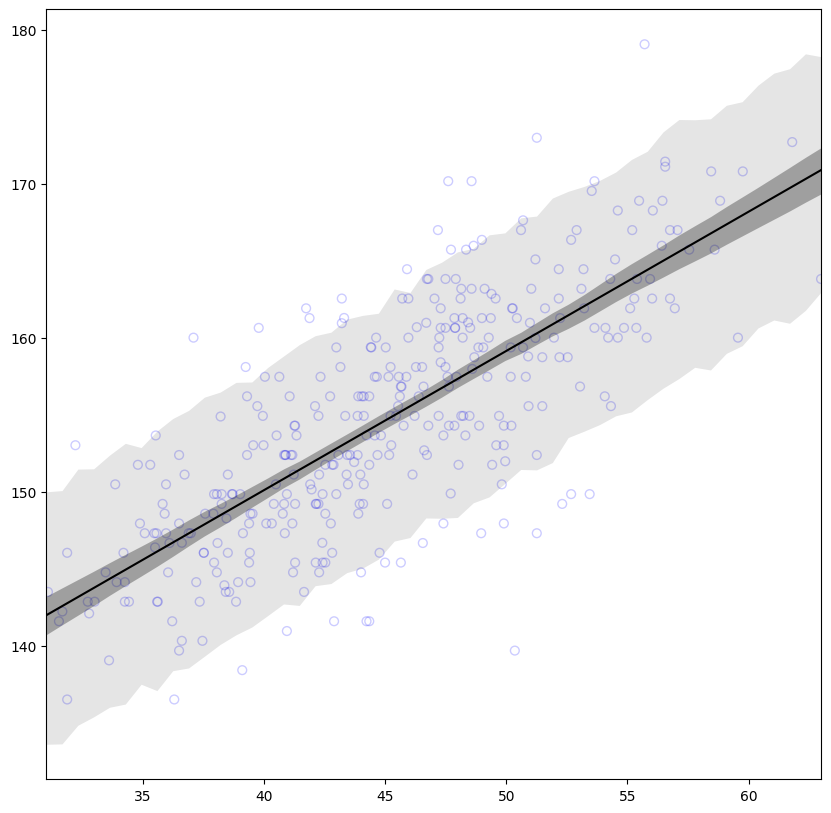

In [27]:
N = 1000
n = 50
alpha_est = tfd.Normal(loc=Mean[0], scale=STD[0]).sample(N).numpy()
beta_est = tfd.Normal(loc=Mean[1], scale=STD[1]).sample(N).numpy()
sigma_est = tfd.Normal(loc=Mean[2], scale=STD[2]).sample(N).numpy()

x = np.linspace(np.round(X.min()),np.round(X.max()), n)
mu_pred = np.zeros((N,len(x)))

for i in range(len(x)):
  mu_pred[:,i] = alpha_est + beta_est * (x[i] - xbar)
mu_mean = np.mean(mu_pred, axis= 0)

sigma_mean = tf.cast(np.mean(sigma_est),tf.float64)
height_pred = np.zeros((N,len(x)))
for i in range(len(x)):
  height_pred[:,i] = tfd.Normal(loc= mu_mean[i], scale= sigma_mean).sample(N).numpy()

mu_HPDI_95 = az.hdi(mu_pred, hdi_prob=0.95).T;
mu_PI_89 = np.percentile(mu_pred, [5,94], axis= 0)
height_PI_89 = np.percentile(height_pred, [5,94], axis= 0)

fig,ax = plt.subplots(figsize=(10,10))
plt.xlim([np.min(x),np.max(x)])
plt.scatter(X, Y, s=40, alpha=0.2, facecolors='None', edgecolors = 'b', marker = "o")
plt.plot(x, mu_mean, '-k')
plt.fill_between(x, mu_HPDI_95[0,:], mu_HPDI_95[1,:], alpha=0.3, linewidth=0, color = 'k')
plt.fill_between(x, height_PI_89[0,:], height_PI_89[1,:], alpha=0.1, linewidth=0, color = 'k')
plt.show()

## **Polynamial Regression**

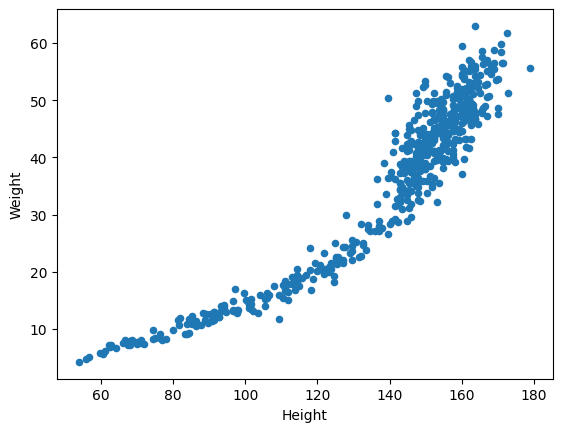

In [28]:
Height = df.height
Weight = df.weight
plt.xlabel("Height")
plt.ylabel("Weight");
plt.scatter(Height, Weight, s=20, alpha=1);
plt.show()

### **Quadratic**

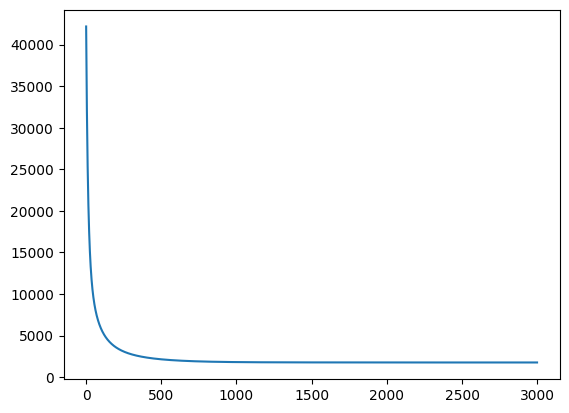

             Mean  Standard Deviation    5.5%   94.5%
Alpha  146.070007                0.25  145.67  146.46
Beta1   21.719999                0.25   21.31   22.12
Beta2   -7.810000                0.17   -8.09   -7.54
Sigma    5.820000                0.18    5.54    6.10
[[ 0.062  0.    -0.     0.   ]
 [ 0.     0.063 -0.    -0.001]
 [-0.    -0.     0.03  -0.   ]
 [ 0.    -0.001 -0.     0.031]]


/tmp/ipykernel_3537/1089948638.py:120: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_HPDI_95 = az.hdi(mu_pred, hdi_prob=0.95).T;


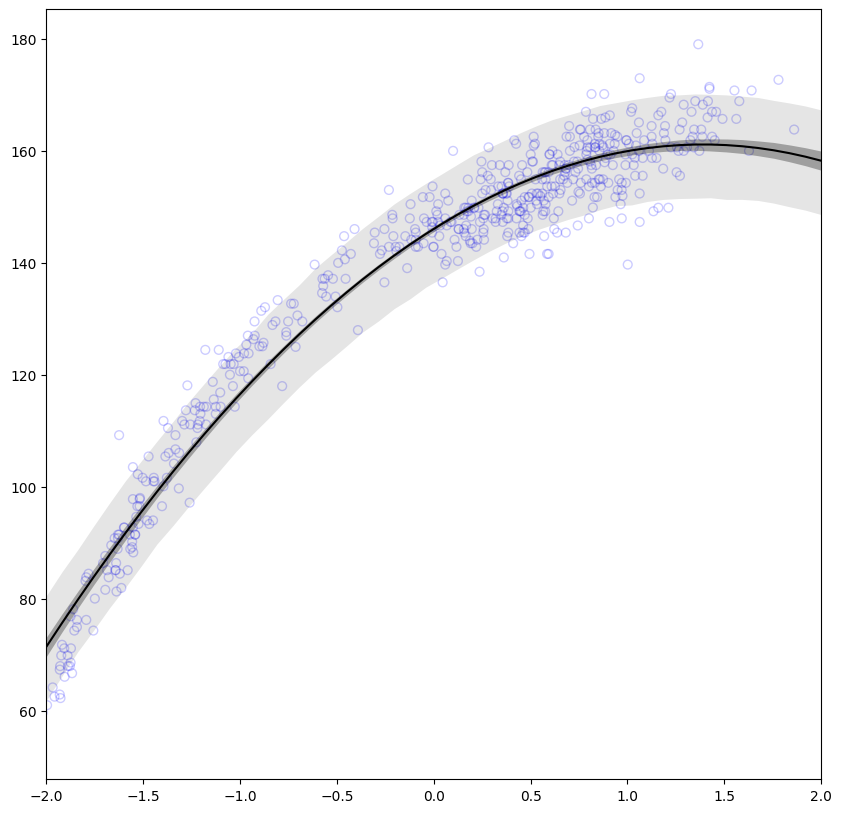

In [29]:
X = (Weight - Weight.mean())/Weight.std() #standardized X
X2 = X**2
Y = Height

dtype = tf.float32

def log_posterior_LR1(alpha, beta1, beta2, sigma, data):
  alpha_prior = tfd.Normal(loc=178., scale=20.0)
  beta1_prior = tfd.LogNormal(loc=0., scale=1.0)
  beta2_prior = tfd.Normal(loc=0., scale=1.0)
  sigma_prior = tfd.Uniform(low=0., high=50.)
  mu = alpha + tf.cast(beta1,dtype)*tf.cast(X.values[:],dtype) +\
               tf.cast(beta2,dtype)*tf.cast(X2.values[:],dtype)
  Y_likelihood = tfd.Normal(loc= mu, scale= sigma)
  return (
      alpha_prior.log_prob(alpha) +\
      beta1_prior.log_prob(beta1) +\
      beta2_prior.log_prob(beta2) +\
      sigma_prior.log_prob(sigma) +\
      tf.reduce_sum(Y_likelihood.log_prob(data))
      )

def Mean_Quadratic(alpha, beta1, beta2, sigma, data):
  losses = tfp.math.minimize(
      lambda: -log_posterior_LR1(alpha, beta1, beta2, sigma, data),
      optimizer=tf.optimizers.Adam(learning_rate=0.05),
      num_steps=3000)
  plt.plot(losses);
  plt.show()
  return (
      alpha.numpy(),
      beta1.numpy(),
      beta2.numpy(),
      sigma.numpy()
  )

def STD_Quadratic(alpha, beta1, beta2, sigma, Func):
  with tf.GradientTape() as g:
    g.watch(alpha)
    with tf.GradientTape() as gg:
      gg.watch(alpha)
      y = -Func(alpha, beta1, beta2, sigma)
    dy_dalpha = gg.gradient(y, alpha)
  d2y_d2alpha = g.gradient(dy_dalpha, alpha)
  with tf.GradientTape() as g:
    g.watch(beta1)
    with tf.GradientTape() as gg:
      gg.watch(beta1)
      y = -Func(alpha, beta1, beta2, sigma)
    dy_dbeta1 = gg.gradient(y, beta1)
  d2y_d2beta1 = g.gradient(dy_dbeta1, beta1)
  with tf.GradientTape() as g:
    g.watch(beta2)
    with tf.GradientTape() as gg:
      gg.watch(beta2)
      y = -Func(alpha, beta1, beta2, sigma)
    dy_dbeta2 = gg.gradient(y, beta2)
  d2y_d2beta2 = g.gradient(dy_dbeta2, beta2)
  with tf.GradientTape() as g:
    g.watch(sigma)
    with tf.GradientTape() as gg:
      gg.watch(sigma)
      y = -Func(alpha, beta1, beta2, sigma)
    dy_dsigma = gg.gradient(y, sigma)
  d2y_d2sigma = g.gradient(dy_dsigma, sigma)
  return (
      ((1/d2y_d2alpha)**0.5 ).numpy(),
      ((1/d2y_d2beta1)**0.5 ).numpy(),
      ((1/d2y_d2beta2)**0.5 ).numpy(),
      ((1/d2y_d2sigma)**0.5 ).numpy()
  )

log_posterior_LR1_forDerivation = lambda alpha,\
                                         beta1,\
                                         beta2,\
                                         sigma: log_posterior_LR1(alpha, beta1, beta2, sigma, Y)

Mean = Mean_Quadratic(tf.Variable(150.),
                      tf.Variable(5.),
                      tf.Variable(-1.),
                      tf.Variable(2.),
                      Y)
STD = STD_Quadratic(tf.convert_to_tensor(Mean[0]),
                    tf.convert_to_tensor(Mean[1]),
                    tf.convert_to_tensor(Mean[2]),
                    tf.convert_to_tensor(Mean[3]),
                    log_posterior_LR1_forDerivation)

N = 10000

alpha_est = tfd.Normal(loc=Mean[0], scale=STD[0]).sample(N).numpy()
beta1_est = tfd.Normal(loc=Mean[1], scale=STD[1]).sample(N).numpy()
beta2_est = tfd.Normal(loc=Mean[2], scale=STD[2]).sample(N).numpy()
sigma_est = tfd.Normal(loc=Mean[3], scale=STD[3]).sample(N).numpy()

Quadratic_est = pd.DataFrame({'Mean': pd.Series({'Alpha': Mean[0], 'Beta1': Mean[1], 'Beta2': Mean[2], 'Sigma': Mean[3]}),
                              'Standard Deviation': pd.Series({'Alpha': STD[0], 'Beta1': STD[1], 'Beta2': STD[2], 'Sigma': STD[3]}),
                              '5.5%': pd.Series({'Alpha': np.percentile(alpha_est,5.5), 'Beta1': np.percentile(beta1_est,5.5), 'Beta2': np.percentile(beta2_est,5.5), 'Sigma': np.percentile(sigma_est,5.5)}),
                              '94.5%': pd.Series({'Alpha': np.percentile(alpha_est,94.5), 'Beta1': np.percentile(beta1_est,94.5), 'Beta2': np.percentile(beta2_est,94.5), 'Sigma': np.percentile(sigma_est,94.5)})
                              })
print(np.round(Quadratic_est, 2))

print(np.round(np.cov(np.stack((alpha_est, beta1_est, beta2_est, sigma_est), axis = 0)),3))

n = 50

x = np.linspace(np.round(X.min()),np.round(X.max()), n)
x2 = x**2
mu_pred = np.zeros((N,len(x)))

for i in range(len(x)):
  mu_pred[:,i] = alpha_est + beta1_est*x[i] + beta2_est*x2[i]
mu_mean = np.mean(mu_pred, axis= 0)

sigma_mean = tf.cast(np.mean(sigma_est),tf.float64)
height_pred = np.zeros((N,len(x)))
for i in range(len(x)):
  height_pred[:,i] = tfd.Normal(loc= mu_mean[i], scale= sigma_mean).sample(N).numpy()

mu_HPDI_95 = az.hdi(mu_pred, hdi_prob=0.95).T;
mu_PI_89 = np.percentile(mu_pred, [5,94], axis= 0)
height_PI_89 = np.percentile(height_pred, [5,94], axis= 0)

fig,ax = plt.subplots(figsize=(10,10))
plt.xlim([np.min(x),np.max(x)])
plt.scatter(X, Y, s=40, alpha=0.2, facecolors='None', edgecolors = 'b', marker = "o")
plt.plot(x, mu_mean, '-k')
plt.fill_between(x, mu_HPDI_95[0,:], mu_HPDI_95[1,:], alpha=0.3, linewidth=0, color = 'k')
plt.fill_between(x, height_PI_89[0,:], height_PI_89[1,:], alpha=0.1, linewidth=0, color = 'k')
plt.show()

### **Cubic**

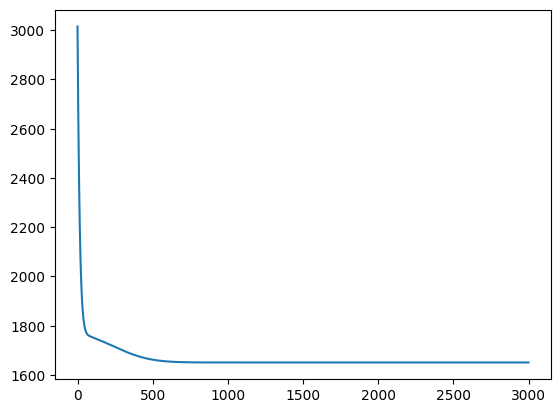

             Mean  Standard Deviation    5.5%   94.5%
Alpha  146.740005                0.21  146.40  147.06
Beta1   15.000000                0.21   14.67   15.33
Beta2   -6.540000                0.14   -6.76   -6.30
Beta3    3.600000                0.09    3.46    3.75
Sigma    4.820000                0.15    4.58    5.06
[[ 0.043  0.    -0.    -0.    -0.   ]
 [ 0.     0.043  0.    -0.     0.   ]
 [-0.     0.     0.021  0.    -0.   ]
 [-0.    -0.     0.     0.008  0.   ]
 [-0.     0.    -0.     0.     0.022]]


/tmp/ipykernel_3537/3215092902.py:154: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_HPDI_95 = az.hdi(mu_pred, hdi_prob=0.95).T;


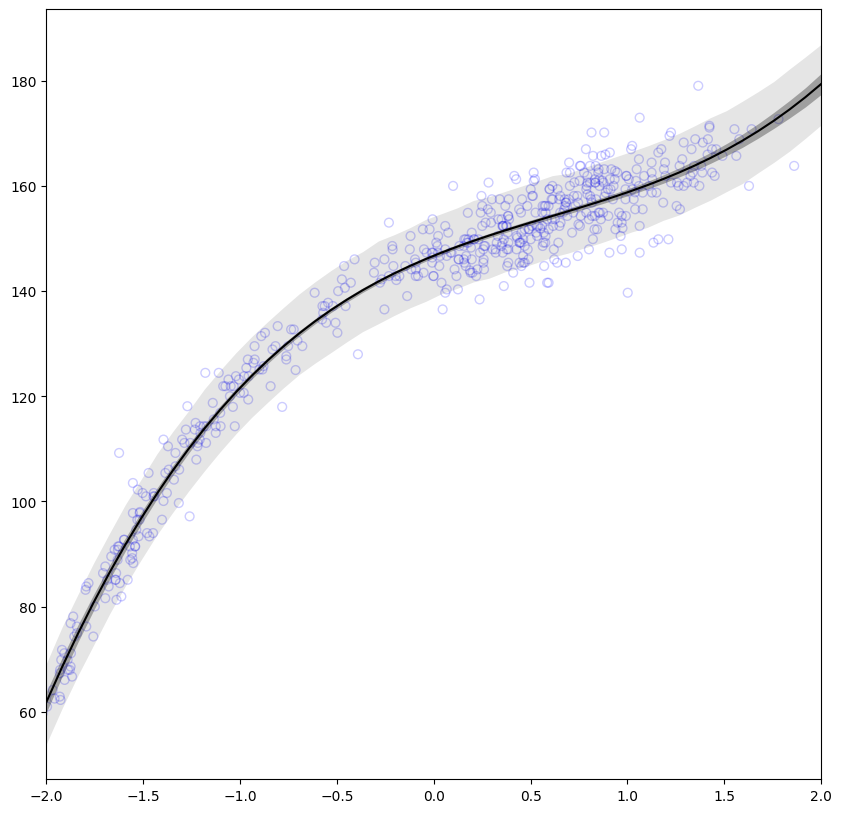

In [30]:
X = (Weight - Weight.mean())/Weight.std() #standardized X
X2 = X**2
X3 = X**3
Y = Height

dtype = tf.float32

def log_posterior_LR1(alpha, beta1, beta2, beta3, sigma, data):
  alpha_prior = tfd.Normal(loc=178., scale=20.0)
  beta1_prior = tfd.LogNormal(loc=0., scale=1.0)
  beta2_prior = tfd.Normal(loc=0., scale=10.0)
  beta3_prior = tfd.Normal(loc=0., scale=10.0)
  sigma_prior = tfd.Uniform(low=0., high=50.)
  mu = alpha + tf.cast(beta1,dtype)*tf.cast(X.values[:],dtype) +\
               tf.cast(beta2,dtype)*tf.cast(X2.values[:],dtype) +\
               tf.cast(beta3,dtype)*tf.cast(X3.values[:],dtype)
  Y_likelihood = tfd.Normal(loc= mu, scale= sigma)
  return (
      alpha_prior.log_prob(alpha) +\
      beta1_prior.log_prob(beta1) +\
      beta2_prior.log_prob(beta2) +\
      beta3_prior.log_prob(beta3) +\
      sigma_prior.log_prob(sigma) +\
      tf.reduce_sum(Y_likelihood.log_prob(data))
      )

def Mean_Quadratic(alpha, beta1, beta2, beta3, sigma, data):
  losses = tfp.math.minimize(
      lambda: -log_posterior_LR1(alpha, beta1, beta2, beta3, sigma, data),
      optimizer=tf.optimizers.Adam(learning_rate=0.05),
      num_steps=3000)
  plt.plot(losses);
  plt.show()
  return (
      alpha.numpy(),
      beta1.numpy(),
      beta2.numpy(),
      beta3.numpy(),
      sigma.numpy()
  )

def STD_Quadratic(alpha, beta1, beta2, beta3, sigma, Func):
  with tf.GradientTape() as g:
    g.watch(alpha)
    with tf.GradientTape() as gg:
      gg.watch(alpha)
      y = -Func(alpha, beta1, beta2, beta3, sigma)
    dy_dalpha = gg.gradient(y, alpha)
  d2y_d2alpha = g.gradient(dy_dalpha, alpha)
  with tf.GradientTape() as g:
    g.watch(beta1)
    with tf.GradientTape() as gg:
      gg.watch(beta1)
      y = -Func(alpha, beta1, beta2, beta3, sigma)
    dy_dbeta1 = gg.gradient(y, beta1)
  d2y_d2beta1 = g.gradient(dy_dbeta1, beta1)
  with tf.GradientTape() as g:
    g.watch(beta2)
    with tf.GradientTape() as gg:
      gg.watch(beta2)
      y = -Func(alpha, beta1, beta2, beta3, sigma)
    dy_dbeta2 = gg.gradient(y, beta2)
  d2y_d2beta2 = g.gradient(dy_dbeta2, beta2)
  with tf.GradientTape() as g:
    g.watch(beta3)
    with tf.GradientTape() as gg:
      gg.watch(beta3)
      y = -Func(alpha, beta1, beta2, beta3, sigma)
    dy_dbeta3 = gg.gradient(y, beta3)
  d2y_d2beta3 = g.gradient(dy_dbeta3, beta3)
  with tf.GradientTape() as g:
    g.watch(sigma)
    with tf.GradientTape() as gg:
      gg.watch(sigma)
      y = -Func(alpha, beta1, beta2, beta3, sigma)
    dy_dsigma = gg.gradient(y, sigma)
  d2y_d2sigma = g.gradient(dy_dsigma, sigma)
  return (
      ((1/d2y_d2alpha)**0.5 ).numpy(),
      ((1/d2y_d2beta1)**0.5 ).numpy(),
      ((1/d2y_d2beta2)**0.5 ).numpy(),
      ((1/d2y_d2beta3)**0.5 ).numpy(),
      ((1/d2y_d2sigma)**0.5 ).numpy()
  )

log_posterior_LR1_forDerivation = lambda alpha,\
                                         beta1,\
                                         beta2,\
                                         beta3,\
                                         sigma: log_posterior_LR1(alpha, beta1, beta2, beta3, sigma, Y)

Mean = Mean_Quadratic(tf.Variable(150.),
                      tf.Variable(5.),
                      tf.Variable(-3.),
                      tf.Variable(5.),
                      tf.Variable(5.),
                      Y)
STD = STD_Quadratic(tf.convert_to_tensor(Mean[0]),
                    tf.convert_to_tensor(Mean[1]),
                    tf.convert_to_tensor(Mean[2]),
                    tf.convert_to_tensor(Mean[3]),
                    tf.convert_to_tensor(Mean[4]),
                    log_posterior_LR1_forDerivation)

N = 10000

alpha_est = tfd.Normal(loc=Mean[0], scale=STD[0]).sample(N).numpy()
beta1_est = tfd.Normal(loc=Mean[1], scale=STD[1]).sample(N).numpy()
beta2_est = tfd.Normal(loc=Mean[2], scale=STD[2]).sample(N).numpy()
beta3_est = tfd.Normal(loc=Mean[3], scale=STD[3]).sample(N).numpy()
sigma_est = tfd.Normal(loc=Mean[4], scale=STD[4]).sample(N).numpy()

Quadratic_est = pd.DataFrame({'Mean': pd.Series({'Alpha': Mean[0],
                                                 'Beta1': Mean[1],
                                                 'Beta2': Mean[2],
                                                 'Beta3': Mean[3],
                                                 'Sigma': Mean[4]}),
                              'Standard Deviation': pd.Series({'Alpha': STD[0],
                                                               'Beta1': STD[1],
                                                               'Beta2': STD[2],
                                                               'Beta3': STD[3],
                                                               'Sigma': STD[4]}),
                              '5.5%': pd.Series({'Alpha': np.percentile(alpha_est,5.5),
                                                 'Beta1': np.percentile(beta1_est,5.5),
                                                 'Beta2': np.percentile(beta2_est,5.5),
                                                 'Beta3': np.percentile(beta3_est,5.5),
                                                 'Sigma': np.percentile(sigma_est,5.5)}),
                              '94.5%': pd.Series({'Alpha': np.percentile(alpha_est,94.5),
                                                  'Beta1': np.percentile(beta1_est,94.5),
                                                  'Beta2': np.percentile(beta2_est,94.5),
                                                  'Beta3': np.percentile(beta3_est,94.5),
                                                  'Sigma': np.percentile(sigma_est,94.5)})
                              })
print(np.round(Quadratic_est, 2))

print(np.round(np.cov(np.stack((alpha_est, beta1_est, beta2_est, beta3_est, sigma_est), axis = 0)),3))

n = 50

x = np.linspace(np.round(X.min()),np.round(X.max()), n)
x2 = x**2
x3 = x**3
mu_pred = np.zeros((N,len(x)))

for i in range(len(x)):
  mu_pred[:,i] = alpha_est + beta1_est*x[i] + beta2_est*x2[i] + beta3_est*x3[i]
mu_mean = np.mean(mu_pred, axis= 0)

sigma_mean = tf.cast(np.mean(sigma_est),tf.float64)
height_pred = np.zeros((N,len(x)))
for i in range(len(x)):
  height_pred[:,i] = tfd.Normal(loc= mu_mean[i], scale= sigma_mean).sample(N).numpy()

mu_HPDI_95 = az.hdi(mu_pred, hdi_prob=0.95).T;
mu_PI_89 = np.percentile(mu_pred, [5,94], axis= 0)
height_PI_89 = np.percentile(height_pred, [5,94], axis= 0)

fig,ax = plt.subplots(figsize=(10,10))
plt.xlim([np.min(x),np.max(x)])
plt.scatter(X, Y, s=40, alpha=0.2, facecolors='None', edgecolors = 'b', marker = "o")
plt.plot(x, mu_mean, '-k')
plt.fill_between(x, mu_HPDI_95[0,:], mu_HPDI_95[1,:], alpha=0.3, linewidth=0, color = 'k')
plt.fill_between(x, height_PI_89[0,:], height_PI_89[1,:], alpha=0.1, linewidth=0, color = 'k')
plt.show()

## **Spline**

In [31]:
with open('./data/cherry_blossoms.csv', 'r') as f:
  df = pd.read_csv(f, sep = ';')

In [32]:
df2 = df[df.doy.notna()]  # not NaN cases on temp
print(df2.describe())
print(df2.head())

              year         doy        temp  temp_upper  temp_lower
count   827.000000  827.000000  787.000000  787.000000  787.000000
mean   1548.841596  104.540508    6.100356    6.937560    5.263545
std     304.149774    6.407036    0.683410    0.811986    0.762194
min     812.000000   86.000000    4.690000    5.450000    2.610000
25%    1325.000000  100.000000    5.625000    6.380000    4.770000
50%    1583.000000  105.000000    6.060000    6.800000    5.250000
75%    1803.500000  109.000000    6.460000    7.375000    5.650000
max    2015.000000  124.000000    8.300000   12.100000    7.740000
    year    doy  temp  temp_upper  temp_lower
11   812   92.0   NaN         NaN         NaN
14   815  105.0   NaN         NaN         NaN
30   831   96.0   NaN         NaN         NaN
50   851  108.0  7.38        12.1        2.66
52   853  104.0   NaN         NaN         NaN


[ 812. 1036. 1174. 1269. 1377. 1454. 1518. 1583. 1650. 1714. 1774. 1833.
 1893. 1956. 2015.]
(827, 17)


/tmp/ipykernel_3537/463566261.py:129: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_HPDI_95 = az.hdi(mu_est.numpy(), hdi_prob=0.95).T;


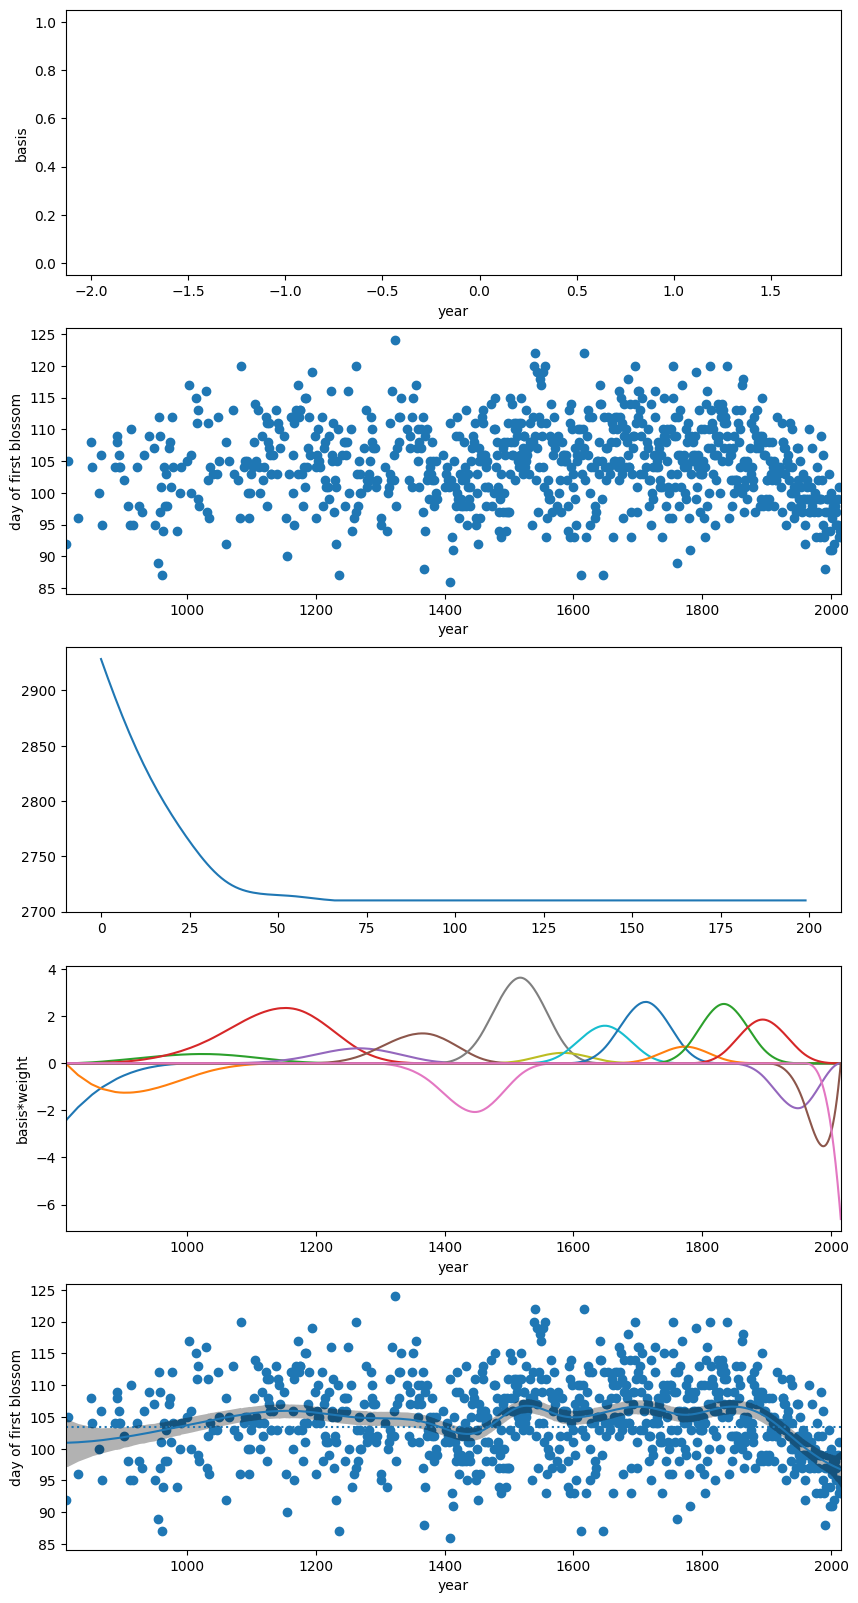

         Mean  Standard Deviation    5.5%   94.5%
Alpha  103.38                0.20  103.05  103.71
w_1     -2.44                1.94   -5.57    0.61
w_2     -2.27                1.18   -4.18   -0.39
w_3      0.70                0.91   -0.78    2.17
w_4      3.34                0.70    2.23    4.45
w_5      0.94                0.76   -0.31    2.16
w_6      1.96                0.79    0.69    3.25
w_7     -3.01                0.72   -4.15   -1.87
w_8      5.35                0.73    4.19    6.51
w_9      0.66                0.77   -0.57    1.88
w_10     2.41                0.77    1.18    3.60
w_11     3.90                0.76    2.69    5.13
w_12     1.05                0.75   -0.14    2.28
w_13     3.75                0.75    2.57    4.96
w_14     2.80                0.77    1.58    4.01
w_15    -3.22                0.88   -4.62   -1.80
w_16    -5.82                1.06   -7.49   -4.08
w_17    -6.62                1.48   -9.02   -4.25
Sigma    5.85                0.14    5.62    6.08


In [33]:
dtype = tf.float64

num_knots = 15  # Number of total knots
degree = 3

knot_list = np.quantile(df2.year, np.linspace(0, 1, num_knots))
knots = np.pad(knot_list, pad_width = (degree, degree), mode="edge")    # Number of boundary knots at each side = degree+1
B = BSpline(knots, np.identity(num_knots+degree-1), degree)(df2.year.values)
_, ax = plt.subplots(5, 1, figsize=(10, 20))
for i in range(num_knots+degree-1):
    ax[0].plot(df2.year, (B[:, i]), color="k")
ax[0].set(xlim=(np.min(X), np.max(X)), xlabel=("year"),ylabel=("basis"))

print(knot_list)
print(B.shape)

Y = df2.doy.values
X = df2.year.values

ax[1].scatter(X, Y)
ax[1].set(xlim=(np.min(X), np.max(X)), xlabel=("year"), ylabel=("day of first blossom"))

def log_posterior_Spline(alpha, w, sigma, data):
  alpha_prior = tfd.Normal(loc=tf.cast(100.,dtype), scale=tf.cast(10.0,dtype))
  w_prior = tfd.Normal(loc=0., scale=tf.cast(10.0,dtype))
  sigma_prior = tfd.Exponential(rate=tf.cast(tf.cast(1.0,dtype), dtype))
  mu = tf.cast(alpha,dtype) + tf.einsum("ij,...j->...i",tf.cast(B,dtype),tf.cast(w,dtype))
  Y_likelihood = tfd.Normal(loc= mu, scale= sigma)
  return (
    alpha_prior.log_prob(alpha) +\
    tf.reduce_sum(w_prior.log_prob(w)) +\
    sigma_prior.log_prob(sigma) +\
    tf.reduce_sum(Y_likelihood.log_prob(data))
  )

def Mean_Quadratic(alpha, w, sigma, data):
  losses = tfp.math.minimize(
      lambda: -log_posterior_Spline(alpha, w, sigma, data),
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
      num_steps=200,
      convergence_criterion= tfp.optimizer.convergence_criteria.LossNotDecreasing(atol=0.5))
  ax[2].plot(losses);
  return (
    alpha.numpy(),
    w.numpy(),
    sigma.numpy()
  )

def STD_Quadratic(alpha, w, sigma, Func):
  with tf.GradientTape() as g:
    g.watch(alpha)
    with tf.GradientTape() as gg:
      gg.watch(alpha)
      y = -Func(alpha, w, sigma)
    dy_dalpha = gg.gradient(y, alpha)
  d2y_d2alpha = g.gradient(dy_dalpha, alpha)
  with tf.GradientTape() as g:
    g.watch(w)
    with tf.GradientTape() as gg:
      gg.watch(w)
      y = -Func(alpha, w, sigma)
    dy_dw = gg.gradient(y, w)
  d2y_d2w = g.gradient(dy_dw, w)
  with tf.GradientTape() as g:
    g.watch(sigma)
    with tf.GradientTape() as gg:
      gg.watch(sigma)
      y = -Func(alpha, w, sigma)
    dy_dsigma = gg.gradient(y, sigma)
  d2y_d2sigma = g.gradient(dy_dsigma, sigma)
  return (
      ((1/d2y_d2alpha)**0.5 ).numpy(),
      ((1/d2y_d2w)**0.5 ).numpy(),
      ((1/d2y_d2sigma)**0.5 ).numpy()
  )

log_posterior_Spline_forDerivation = lambda alpha,\
                                         w,\
                                         sigma: log_posterior_Spline(alpha, w, sigma, Y)

Mean = Mean_Quadratic(tf.Variable(tf.cast(102,dtype)),
                      tf.Variable(tf.cast(np.repeat(0., num_knots+degree-1), dtype)),
                      tf.Variable(tf.cast(10,dtype)),
                      tf.cast(Y,dtype))

ax[3].set(xlim=(np.min(X), np.max(X)), xlabel=("year"), ylabel=("basis*weight"))
for i in range(num_knots+degree-1):
    ax[3].plot(X, B[:,i]*Mean[1][i])

Y_est = Mean[0] + tf.einsum("ij,...j->...i",B,np.array(Mean[1]))
ax[4].scatter(X, Y)
ax[4].set(xlim=(np.min(X), np.max(X)), xlabel=("year"), ylabel=("day of first blossom"))
ax[4].plot(X, Y_est)
                      
STD = STD_Quadratic(tf.convert_to_tensor(Mean[0]),
                    tf.convert_to_tensor(Mean[1]),
                    tf.convert_to_tensor(Mean[2]),
                    log_posterior_Spline_forDerivation)

N = 10000

alpha_est = tfd.Normal(loc=Mean[0], scale=STD[0]).sample(N).numpy()
w_est = tfd.Normal(loc=Mean[1], scale=STD[1]).sample(N).numpy()
sigma_est = tfd.Normal(loc=Mean[2], scale=STD[2]).sample(N).numpy()

d_alpha = {'Mean': pd.Series(Mean[0], index=['Alpha']),
           'Standard Deviation': pd.Series(STD[0], index=['Alpha']),
           '5.5%': pd.Series(np.percentile(alpha_est,5.5), index=['Alpha']),
           '94.5%': pd.Series(np.percentile(alpha_est,94.5), index=['Alpha'])}

d_w = {'Mean': pd.Series(Mean[1][:], index=['w_'+str(i+1) for i in range(17)]),
       'Standard Deviation': pd.Series(STD[1][:], index=['w_'+str(i+1) for i in range(17)]),
       '5.5%': pd.Series([np.percentile(w_est[:,i],5.5) for i in range(17)], index=['w_'+str(i+1) for i in range(17)]),
       '94.5%': pd.Series([np.percentile(w_est[:,i],94.5) for i in range(17)], index=['w_'+str(i+1) for i in range(17)])}

d_sigma = {'Mean': pd.Series(Mean[2], index=['Sigma']),
           'Standard Deviation': pd.Series(STD[2], index=['Sigma']),
           '5.5%': pd.Series(np.percentile(sigma_est,5.5), index=['Sigma']),
           '94.5%': pd.Series(np.percentile(sigma_est,94.5), index=['Sigma'])}

df_alpha = pd.DataFrame(d_alpha)
df_w = pd.DataFrame(d_w)
df_sigma = pd.DataFrame(d_sigma)
Quadratic_est2 = pd.concat([df_alpha,df_w,df_sigma])
#print(np.round(np.cov(np.stack((alpha_est, w_est, sigma_est), axis = 0)),19))

mu_est = np.repeat(alpha_est,827).reshape(10000,827) + tf.einsum("ij,...j->...i",B,w_est)

mu_HPDI_95 = az.hdi(mu_est.numpy(), hdi_prob=0.95).T;
mu_PI_89 = np.percentile(mu_est.numpy(), [5,94], axis= 0)

ax[4].axhline(y=np.mean(alpha_est), linestyle = 'dotted')
ax[4].fill_between(X, mu_HPDI_95[0,:], mu_HPDI_95[1,:], alpha=0.3, linewidth=0, color = 'k')
#plt.fill_between(x, height_PI_89[0,:], height_PI_89[1,:], alpha=0.1, linewidth=0, color = 'k')
plt.show()

print(np.round(Quadratic_est2, 2))